In [2]:
import model
import model_img
import fastText
from keras.callbacks import ModelCheckpoint, Callback
from keras.models import load_model, Model
from keras.optimizers import *
from keras.layers import *
from keras import regularizers
from importlib import reload
from sklearn import metrics as sklm
import numpy as np
import keras.backend as K

In [3]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
reload(model_img)
reload(model)

<module 'model' from '/srv/home/gwiedemann/pss-lre/model.py'>

## Text model features

In [4]:
data_text_train = model.read_csv_data("data/Tobacco800/dataset.train", csvformat="Tobacco800")
data_text_test = model.read_csv_data("data/Tobacco800/dataset.test", csvformat="Tobacco800")

In [5]:
if 'ft' not in locals():
    ft = fastText.load_model("./../embeddings/wiki.en.bin")
    model.ft = ft

In [6]:
# model_text = load_model("models/exp1_single-page_repeat-07.hdf5")
model_text = load_model("models/tobacco800_exp1_prev-page_repeat-06.hdf5")

In [7]:
_, y_true, _, _, _ = zip(*data_text_test)
y_true = [1 if y == 'FirstPage' else 0 for y in y_true]
y_predict = np.round(model_text.predict_generator(model.TextFeatureGenerator2(data_text_test)))
print("Accuracy: " + str(sklm.accuracy_score(y_true, y_predict)))
print("Kappa: " + str(sklm.cohen_kappa_score(y_true, y_predict)))

Accuracy: 0.8687258687258688
Kappa: 0.7300263658102888


In [8]:
model_text.layers.pop()
model_text_features = Model(model_text.input, model_text.layers[-1].output)

In [9]:
text_features_train = model_text_features.predict_generator(model.TextFeatureGenerator2(data_text_train))
text_features_test = model_text_features.predict_generator(model.TextFeatureGenerator2(data_text_test))

## Image model features

In [10]:
img_dim = (224,224)
model_img.img_path_template = 'data/Tobacco800/images/%s.tif.small.png'

In [11]:
data_image_train = model_img.read_csv_data("data/Tobacco800/dataset.train", csvformat="Tobacco800")
data_image_test = model_img.read_csv_data("data/Tobacco800/dataset.test", csvformat="Tobacco800")

In [12]:
# model_image = load_model("models/exp2_img_repeat-07.hdf5")
model_image = load_model("models/Tobacco800_exp2_prev-page_repeat-05.hdf5")

In [13]:
_, y_true, _, _, _ = zip(*data_text_test)
y_true = [1 if y == 'FirstPage' else 0 for y in y_true]
y_predict = np.round(model_image.predict_generator(model_img.ImageFeatureGenerator(data_image_test, img_dim, prevpage=True)))
print("Accuracy: " + str(sklm.accuracy_score(y_true, y_predict)))
print("Kappa: " + str(sklm.cohen_kappa_score(y_true, y_predict)))

Accuracy: 0.9111969111969112
Kappa: 0.8157495901766108


In [14]:
model_image.layers.pop()
model_image_features = Model(model_image.input, model_image.layers[-1].output)

In [15]:
image_features_train = model_image_features.predict_generator(model_img.ImageFeatureGenerator(data_image_train, img_dim, prevpage=True))
image_features_test = model_image_features.predict_generator(model_img.ImageFeatureGenerator(data_image_test, img_dim, prevpage=True))

# Training and test targets

In [16]:
# Training data
_, data_train_y, _, _, _ = zip(*data_text_train)
data_train_y = [1 if y == 'FirstPage' else 0 for y in data_train_y]
# Test data
_, data_test_y, _, _, _ = zip(*data_text_test)
data_test_y = [1 if y == 'FirstPage' else 0 for y in data_test_y]

In [17]:
class ValidationCheckpoint(Callback):
    def __init__(self, filepath, validation_x, validation_y, metric = 'kappa'):
        self.metric = metric
        self.max_metric = float('-inf')
        self.max_metrics = None
        self.filepath = filepath
        self.history = []
        self.validation_x = validation_x
        self.validation_y = validation_y

    def on_epoch_end(self, epoch, logs={}):
        
        predicted_labels = np.round(self.model.predict(self.validation_x))
        true_labels = self.validation_y

        eval_metrics = {
            'accuracy' : sklm.accuracy_score(true_labels, predicted_labels),
            'f1_micro' : sklm.f1_score(true_labels, predicted_labels, average='micro'),
            'f1_macro' : sklm.f1_score(true_labels, predicted_labels, average='macro'),
            'f1_binary' : sklm.f1_score(true_labels, predicted_labels, average='binary', pos_label = 1),
            'kappa' : sklm.cohen_kappa_score(true_labels, predicted_labels)
        }
        eval_metric = eval_metrics[self.metric]
        self.history.append(eval_metric)
        
        if epoch > -1 and eval_metric > self.max_metric:
            print("\n" + self.metric + " improvement: " + str(eval_metric) + " (before: " + str(self.max_metric) + "), saving to " + self.filepath)
            self.max_metric = eval_metric     # optimization target
            self.max_metrics = eval_metrics   # all metrics
            self.model.save(self.filepath)

## LDA Features

In [18]:
lda_train_x = []
with open("data/Tobacco800/lda_train.csv") as f:
    next(f)
    for l in f:
        lda_train_x.append([float(n) for n in l.split(",")])
lda_train_x = np.array(lda_train_x)
print(lda_train_x.shape)

lda_test_x = []
with open("data/Tobacco800/lda_test.csv") as f:
    next(f)
    for l in f:
        lda_test_x.append([float(n) for n in l.split(",")])
lda_test_x = np.array(lda_test_x)
print(lda_test_x.shape)

(1031, 52)
(259, 52)


In [19]:
features_x_train = lda_train_x
features_x_test = lda_test_x
sequence_x_train = np.empty((len(features_x_train),2,len(features_x_train[0])))
sep_tp_x_train = np.empty((len(features_x_train),len(features_x_train[0])))
sep_pp_x_train = np.empty((len(features_x_train),len(features_x_train[0])))
for i, d in enumerate(features_x_train):
    if d[3] == "":
        prev_page = np.zeros((1,len(features_x_train[0])))
    else:
        prev_page = features_x_train[i-1]
    sequence_x_train[i][0] = sep_pp_x_train[i] = prev_page
    sequence_x_train[i][1] = sep_tp_x_train[i] = features_x_train[i]

sequence_x_test = np.empty((len(features_x_test),2,len(features_x_test[0])))
sep_tp_x_test = np.empty((len(features_x_test),len(features_x_test[0])))
sep_pp_x_test = np.empty((len(features_x_test),len(features_x_test[0])))
for i, d in enumerate(features_x_test):
    if d[3] == "":
        prev_page = np.zeros((1,len(features_x_test[0])))
    else:
        prev_page = features_x_test[i-1]
    sequence_x_test[i][0] = sep_pp_x_test[i] = prev_page
    sequence_x_test[i][1] = sep_tp_x_test[i] = features_x_test[i]
print(sep_tp_x_train.shape)
print(sep_pp_x_train.shape)
print(sep_tp_x_test.shape)
print(sep_pp_x_test.shape)

(1031, 52)
(1031, 52)
(259, 52)
(259, 52)


In [20]:
sequence_x_2inputs_train = [sep_tp_x_train, sep_pp_x_train]
sequence_x_2inputs_test = [sep_tp_x_test, sep_pp_x_test]

In [23]:
input_tp = Input(shape=sequence_x_2inputs_train[0][0].shape)
input_pp = Input(shape=sequence_x_2inputs_train[1][0].shape)
difference = subtract([input_pp, input_tp])
final_feat = concatenate([input_tp, input_pp, difference])
final_feat = Dense(400)(final_feat)
final_feat = LeakyReLU()(final_feat)
final_feat = Dropout(0.9)(final_feat)
model_output = Dense(1, activation = 'sigmoid')(final_feat)
combined_model = Model([input_tp, input_pp], model_output)
model_path = "Tobacco800_exp3_img-text_lda_model.hdf5"
checkpoint = ValidationCheckpoint(model_path, sequence_x_2inputs_test, data_test_y)
combined_model.compile(loss = 'binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
combined_model.fit(sequence_x_2inputs_train, data_train_y, validation_data = (sequence_x_2inputs_test, data_test_y), 
                   batch_size=4096, epochs=40, callbacks=[checkpoint])


Train on 1031 samples, validate on 259 samples
Epoch 1/40
1031/1031 [==============================] - 3s 3ms/step - loss: 0.7090 - acc: 0.4985 - val_loss: 0.6468 - val_acc: 0.6139

kappa improvement: 0.09699463077888582 (before: -inf), saving to Tobacco800_exp3_img-text_lda_model.hdf5
Epoch 2/40
1031/1031 [==============================] - 0s 9us/step - loss: 0.6676 - acc: 0.5752 - val_loss: 0.6288 - val_acc: 0.6139
Epoch 3/40
1031/1031 [==============================] - 0s 8us/step - loss: 0.6375 - acc: 0.6382 - val_loss: 0.6159 - val_acc: 0.6371

kappa improvement: 0.15839325221238942 (before: 0.09699463077888582), saving to Tobacco800_exp3_img-text_lda_model.hdf5
Epoch 4/40
1031/1031 [==============================] - 0s 10us/step - loss: 0.6204 - acc: 0.6625 - val_loss: 0.6042 - val_acc: 0.6602

kappa improvement: 0.21875642695550834 (before: 0.15839325221238942), saving to Tobacco800_exp3_img-text_lda_model.hdf5
Epoch 5/40
1031/1031 [==============================] - 0s 9us/step 

Epoch 40/40
1031/1031 [==============================] - 0s 6us/step - loss: 0.3586 - acc: 0.8710 - val_loss: 0.3853 - val_acc: 0.8610


# Late Fusion

In [21]:
model_text = load_model("models/tobacco800_exp1_prev-page_repeat-06.hdf5")
model_image = load_model("models/Tobacco800_exp2_prev-page_repeat-05.hdf5")
model_lda = load_model("models/Tobacco800_exp3_img-text_lda_model.hdf5")

In [32]:
p_t_train = model_text.predict_generator(model.TextFeatureGenerator2(data_text_train))
p_v_train = model_image.predict_generator(model_img.ImageFeatureGenerator(data_image_train, img_dim, prevpage=True))
p_l_train = model_lda.predict(sequence_x_2inputs_train)
p_t_train = np.concatenate([1 - p_t_train, p_t_train], axis = 1) # probability from text model
p_v_train = np.concatenate([1 - p_v_train, p_v_train], axis = 1) # probability from visual model
p_l_train = np.concatenate([1 - p_l_train, p_l_train], axis = 1) # probability from lda model

In [33]:
p_t_test = model_text.predict_generator(model.TextFeatureGenerator2(data_text_test))
p_v_test = model_image.predict_generator(model_img.ImageFeatureGenerator(data_image_test, img_dim, prevpage=True))
p_l_test = model_lda.predict(sequence_x_2inputs_test)
p_t_test = np.concatenate([1 - p_t_test, p_t_test], axis = 1) # probability from text model
p_v_test = np.concatenate([1 - p_v_test, p_v_test], axis = 1) # probability from visual model
p_l_test = np.concatenate([1 - p_l_test, p_l_test], axis = 1) # probability from lda model

In [56]:
# scoring with diffent i, j in (0,1] power normalizations
max_kappa = 0
test_exponents = [x / 10 for x in range(1,11)]
for i in test_exponents:
    for j in test_exponents:
        for k in test_exponents:
            y_predict = np.argmax(np.power(p_t_test, i) * np.power(p_v_test, j) * np.power(p_l_test, k), axis = 1)
            acc = sklm.accuracy_score(y_true, y_predict)
            kappa = sklm.cohen_kappa_score(y_true, y_predict)
            if kappa > max_kappa:
                max_kappa = kappa
                print(str(i) + " " + str(j) + " " + str(k))
                print("Accuracy: " + str(acc))
                print("Kappa: " + str(kappa))

# Best results: i = 0.4 k = 0.1 j = 0.2
# Accuracy: 0.9338567222767419
# Kappa: 0.7078080262749252

0.1 0.1 0.1
Accuracy: 0.915057915057915
Kappa: 0.8244284217661921


In [50]:
i = 0.1
j = 0.2
k = 0.1 
y_predict = np.argmax(np.power(p_t_test, i) * np.power(p_v_test, j) * np.power(p_l_test, k), axis = 1)
acc = sklm.accuracy_score(y_true, y_predict)
kappa = sklm.cohen_kappa_score(y_true, y_predict)
print(str(i) + " " + str(j) + " " + str(k))
print("Accuracy: " + str(acc))
print("Kappa: " + str(kappa))

0.1 0.2 0.1
Accuracy: 0.918918918918919
Kappa: 0.8313436075537226


*Training set*
......

with LDA

0.1 0.2 0.1
Accuracy: 0.918918918918919
Kappa: 0.8313436075537226

without LDA

0.1 0.1
Accuracy: 0.915057915057915
Kappa: 0.8244284217661921


*Test set*
.......

0.1 0.1 without LDA
Accuracy: 0.915057915057915
Kappa: 0.8244284217661921

0.1 0.3 0.4 with LDA
Accuracy: 0.9305019305019305
Kappa: 0.8548838946647576

data/Tobacco800/images/tza31a00.tif.small.png
data/Tobacco800/images/vrr09c00-page03_1.tif.small.png
data/Tobacco800/images/wau30a00-page9_10.tif.small.png
data/Tobacco800/images/wdf61f00-page2_1.tif.small.png
data/Tobacco800/images/yru03f00-page03_1.tif.small.png
5


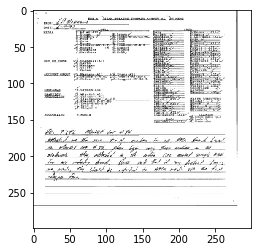

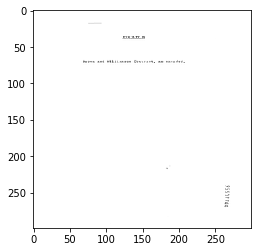

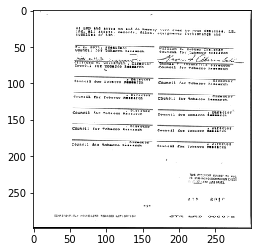

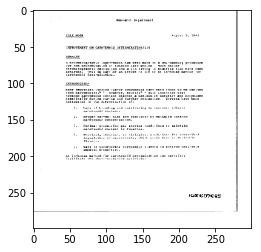

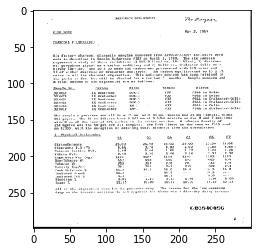

In [54]:
from matplotlib.pyplot import imshow, figure
from keras.preprocessing.image import load_img
i = 0.1
j = 0.2 
k = 0.1
n = 0
y_predict = np.argmax(np.power(p_t_test, i) * np.power(p_v_test, j) * np.power(p_l_test, k), axis = 1)
for i_y, y in enumerate(y_predict):
    if y==0 and y_true[i_y] == 1:
        img_path = 'data/Tobacco800/images/%s.tif.small.png' % data_text_test[i_y][0]
        print(img_path)
        image = load_img(img_path)
        figure()
        imshow(image)
        n += 1
print(n) # 5 FN (handwriting,...), 16 FP (real 1st pages, tables/figures/complex layout)

# Early Fusion

In [29]:
# with LDA
# features_x_train = np.concatenate([text_features_train, lda_train_x], axis = 1)
# features_x_test = np.concatenate([text_features_test, lda_test_x], axis = 1)

# without LDA
features_x_train = text_features_train
features_x_test = text_features_test

In [30]:
data_train_x = [features_x_train, image_features_train]
data_test_x = [features_x_test, image_features_test]
print(len(data_train_x[0][0]))
print(len(data_train_x[1][0]))

256
256


In [ ]:
first_page_share = np.sum(data_train_y) / len(data_train_y)
class_weights = {0 : first_page_share, 1 : (1 - first_page_share)}
print(class_weights)

In [31]:
n_repeats = 10
all_acc = []
all_kap = []
for n_repeat in range(n_repeats):
    text_input = Input(shape=(len(data_train_x[0][0]),))
    img_input = Input(shape=(len(data_train_x[1][0]),))
    combined = concatenate([text_input, img_input])
    combined = Dense(400)(combined)
    combined = LeakyReLU()(combined)
    combined = Dropout(0.5)(combined)
    model_output = Dense(1, activation = 'sigmoid')(combined)
    combined_model = Model([text_input, img_input], model_output)

    model_path = "Tobacco800_exp3_img-text_mlp_simple.hdf5"
    checkpoint = ValidationCheckpoint(model_path, data_test_x, data_test_y)
    combined_model.compile(loss = 'binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

    combined_model.fit(data_train_x, data_train_y, 
                       validation_data = (data_test_x, data_test_y), 
                       batch_size=32, epochs=25, 
                       callbacks=[checkpoint])

    combined_model.load_weights(model_path)
    y_predict = np.round(combined_model.predict(data_test_x))
    all_acc.append(sklm.accuracy_score(data_test_y, y_predict))
    all_kap.append(sklm.cohen_kappa_score(data_test_y, y_predict))
    print("Accuracy: " + str(all_acc[-1]))
    print("Kappa: " + str(all_kap[-1]))
print(np.average(np.array(all_acc)))
print(np.average(np.array(all_kap)))

Train on 1031 samples, validate on 259 samples
Epoch 1/25
1031/1031 [==============================] - 3s 3ms/step - loss: 0.0557 - acc: 0.9748 - val_loss: 0.8346 - val_acc: 0.8958

kappa improvement: 0.7864145872148072 (before: -inf), saving to Tobacco800_exp3_img-text_mlp_simple.hdf5
Epoch 2/25
1031/1031 [==============================] - 0s 191us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.8166 - val_acc: 0.8958
Epoch 3/25
1031/1031 [==============================] - 0s 179us/step - loss: 3.2591e-04 - acc: 1.0000 - val_loss: 0.8187 - val_acc: 0.8880
Epoch 4/25
1031/1031 [==============================] - 0s 357us/step - loss: 6.3986e-04 - acc: 1.0000 - val_loss: 0.7835 - val_acc: 0.8880
Epoch 5/25
1031/1031 [==============================] - 0s 262us/step - loss: 3.0395e-04 - acc: 1.0000 - val_loss: 0.7756 - val_acc: 0.8996

kappa improvement: 0.7935495738549267 (before: 0.7864145872148072), saving to Tobacco800_exp3_img-text_mlp_simple.hdf5
Epoch 6/25
1031/1031 [===============

1031/1031 [==============================] - 4s 4ms/step - loss: 0.0328 - acc: 0.9874 - val_loss: 0.8242 - val_acc: 0.8764

kappa improvement: 0.7521382857826424 (before: -inf), saving to Tobacco800_exp3_img-text_mlp_simple.hdf5
Epoch 2/25
1031/1031 [==============================] - 0s 214us/step - loss: 0.0023 - acc: 0.9990 - val_loss: 0.7319 - val_acc: 0.8958

kappa improvement: 0.7869481765834934 (before: 0.7521382857826424), saving to Tobacco800_exp3_img-text_mlp_simple.hdf5
Epoch 3/25
1031/1031 [==============================] - 0s 200us/step - loss: 5.2859e-04 - acc: 1.0000 - val_loss: 0.7529 - val_acc: 0.8880
Epoch 4/25
1031/1031 [==============================] - 0s 158us/step - loss: 3.0828e-04 - acc: 1.0000 - val_loss: 0.7628 - val_acc: 0.8880
Epoch 5/25
1031/1031 [==============================] - 0s 138us/step - loss: 4.1436e-04 - acc: 1.0000 - val_loss: 0.7988 - val_acc: 0.8919
Epoch 6/25
1031/1031 [==============================] - 0s 129us/step - loss: 1.4509e-04 - acc:

Epoch 2/25
1031/1031 [==============================] - 0s 172us/step - loss: 0.0033 - acc: 0.9990 - val_loss: 0.8126 - val_acc: 0.8996

kappa improvement: 0.7956049292782128 (before: 0.7880073968533059), saving to Tobacco800_exp3_img-text_mlp_simple.hdf5
Epoch 3/25
1031/1031 [==============================] - 0s 156us/step - loss: 2.9692e-04 - acc: 1.0000 - val_loss: 0.7893 - val_acc: 0.8958
Epoch 4/25
1031/1031 [==============================] - 0s 137us/step - loss: 1.9937e-04 - acc: 1.0000 - val_loss: 0.7911 - val_acc: 0.8958
Epoch 5/25
1031/1031 [==============================] - 0s 131us/step - loss: 2.5154e-04 - acc: 1.0000 - val_loss: 0.7835 - val_acc: 0.8919
Epoch 6/25
1031/1031 [==============================] - 0s 143us/step - loss: 1.7844e-04 - acc: 1.0000 - val_loss: 0.7811 - val_acc: 0.8919
Epoch 7/25
1031/1031 [==============================] - 0s 181us/step - loss: 1.3030e-04 - acc: 1.0000 - val_loss: 0.7893 - val_acc: 0.8880
Epoch 8/25
1031/1031 [======================

1031/1031 [==============================] - 0s 189us/step - loss: 7.2293e-04 - acc: 1.0000 - val_loss: 0.6829 - val_acc: 0.9035

kappa improvement: 0.8027297931328642 (before: 0.7940672782874618), saving to Tobacco800_exp3_img-text_mlp_simple.hdf5
Epoch 4/25
1031/1031 [==============================] - 0s 157us/step - loss: 1.3365e-04 - acc: 1.0000 - val_loss: 0.6816 - val_acc: 0.9035
Epoch 5/25
1031/1031 [==============================] - 0s 127us/step - loss: 3.5842e-04 - acc: 1.0000 - val_loss: 0.6822 - val_acc: 0.8919
Epoch 6/25
1031/1031 [==============================] - 0s 142us/step - loss: 8.9531e-04 - acc: 1.0000 - val_loss: 0.6791 - val_acc: 0.9073

kappa improvement: 0.8103837471783296 (before: 0.8027297931328642), saving to Tobacco800_exp3_img-text_mlp_simple.hdf5
Epoch 7/25
1031/1031 [==============================] - 0s 145us/step - loss: 2.8552e-04 - acc: 1.0000 - val_loss: 0.6948 - val_acc: 0.8958
Epoch 8/25
1031/1031 [==============================] - 0s 135us/step -

1031/1031 [==============================] - 0s 149us/step - loss: 1.4746e-04 - acc: 1.0000 - val_loss: 0.7616 - val_acc: 0.8958

kappa improvement: 0.7869481765834934 (before: 0.7793330087633885), saving to Tobacco800_exp3_img-text_mlp_simple.hdf5
Epoch 5/25
1031/1031 [==============================] - 0s 153us/step - loss: 2.2871e-04 - acc: 1.0000 - val_loss: 0.7739 - val_acc: 0.8958

kappa improvement: 0.7874791065187662 (before: 0.7869481765834934), saving to Tobacco800_exp3_img-text_mlp_simple.hdf5
Epoch 6/25
1031/1031 [==============================] - 0s 132us/step - loss: 3.6157e-04 - acc: 1.0000 - val_loss: 0.7769 - val_acc: 0.8958
Epoch 7/25
1031/1031 [==============================] - 0s 166us/step - loss: 1.4512e-04 - acc: 1.0000 - val_loss: 0.7743 - val_acc: 0.8958
Epoch 8/25
1031/1031 [==============================] - 0s 158us/step - loss: 1.1911e-04 - acc: 1.0000 - val_loss: 0.7624 - val_acc: 0.8919
Epoch 9/25
1031/1031 [==============================] - 0s 126us/step -

In [50]:
combined_model.load_weights(model_path)
y_predict = np.round(combined_model.predict(data_test_x))
print("Accuracy: " + str(sklm.accuracy_score(data_test_y, y_predict)))
print("Kappa: " + str(sklm.cohen_kappa_score(data_test_y, y_predict)))

Accuracy: 0.8841698841698842
Kappa: 0.7568988173455979


In [ ]:
Early fusion with LDA ()

Accuracy: 0.9061776061776061
Kappa: 0.8069826853972477

Early fusion without LDA

Accuracy: 0.9054054054054055
Kappa: 0.0.8051798979324678

--

extract 10 fp and 10 fn files

# MLP: predecessor page
* extract features from text and image
* combine 2 in sequence RNN

In [51]:
features_x_train = np.concatenate([text_features_train, image_features_train, lda_train_x], axis = 1)
features_x_test = np.concatenate([text_features_test, image_features_test, lda_test_x], axis = 1)

In [52]:
sequence_x_train = np.empty((len(features_x_train),2,len(features_x_train[0])))
sep_tp_x_train = np.empty((len(features_x_train),len(features_x_train[0])))
sep_pp_x_train = np.empty((len(features_x_train),len(features_x_train[0])))
for i, d in enumerate(features_x_train):
    if d[3] == "":
        prev_page = np.zeros((1,len(features_x_train[0])))
    else:
        prev_page = features_x_train[i-1]
    sequence_x_train[i][0] = sep_pp_x_train[i] = prev_page
    sequence_x_train[i][1] = sep_tp_x_train[i] = features_x_train[i]

sequence_x_test = np.empty((len(features_x_test),2,len(features_x_test[0])))
sep_tp_x_test = np.empty((len(features_x_test),len(features_x_test[0])))
sep_pp_x_test = np.empty((len(features_x_test),len(features_x_test[0])))
for i, d in enumerate(features_x_test):
    if d[3] == "":
        prev_page = np.zeros((1,len(features_x_test[0])))
    else:
        prev_page = features_x_test[i-1]
    sequence_x_test[i][0] = sep_pp_x_test[i] = prev_page
    sequence_x_test[i][1] = sep_tp_x_test[i] = features_x_test[i]

In [53]:
print(sep_tp_x_train.shape)
print(sep_pp_x_train.shape)
print(sep_tp_x_test.shape)
print(sep_pp_x_test.shape)

(1031, 564)
(1031, 564)
(259, 564)
(259, 564)


In [54]:
sequence_x_train.shape

(1031, 2, 564)

In [55]:
model_path = "Tobacco_exp3_img-text_rnn-model.hdf5"
checkpoint = ValidationCheckpoint(model_path, sequence_x_test, data_test_y)

sgd = SGD(lr=1e-3, decay=1e-6, nesterov=True)

rnn_input = Input(shape=sequence_x_train[0].shape,)
#attention_probs = Dense(sequence_x_train[1][0].shape[0], activation='softmax')(rnn_input)
#attention_mul = multiply([rnn_input, attention_probs])
rnn_block = Bidirectional(GRU(300, return_sequences = True))(rnn_input)
rnn_block = Bidirectional(GRU(300))(rnn_block)
combined = Dense(128)(rnn_block)
combined = LeakyReLU()(combined)
model_output = Dense(1, activation = 'sigmoid')(combined)
combined_model = Model([rnn_input], model_output)
combined_model.compile(loss = 'binary_crossentropy', optimizer=Nadam(lr=1e-5), metrics=['accuracy'])
combined_model.fit(sequence_x_train, data_train_y, validation_data = (sequence_x_test, data_test_y), 
                   batch_size=32, epochs=2, callbacks=[checkpoint])

Train on 1031 samples, validate on 259 samples
Epoch 1/2
1031/1031 [==============================] - 6s 6ms/step - loss: 0.6114 - acc: 0.6857 - val_loss: 0.5471 - val_acc: 0.7568

kappa improvement: 0.47673411794888243 (before: -inf), saving to Tobacco_exp3_img-text_rnn-model.hdf5
Epoch 2/2
1031/1031 [==============================] - 1s 735us/step - loss: 0.4355 - acc: 0.8603 - val_loss: 0.4560 - val_acc: 0.8069

kappa improvement: 0.590630334450275 (before: 0.47673411794888243), saving to Tobacco_exp3_img-text_rnn-model.hdf5


In [56]:
feature_input = Input(shape=sequence_x_train[0].shape)
combined = Flatten()(feature_input)
combined = Dropout(0.25)(combined)
combined = Dense(300, activation = 'relu')(combined)
model_output = Dense(1, activation = 'sigmoid')(combined)
combined_model = Model([feature_input], model_output)
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model_path = "Tobacco_exp3_img-text_mlp_model.hdf5"
checkpoint = ValidationCheckpoint(model_path, sequence_x_test, data_test_y)
combined_model.compile(loss = 'binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
combined_model.fit(sequence_x_train, data_train_y, validation_data = (sequence_x_test, data_test_y), 
                   batch_size=256, epochs=10, callbacks=[checkpoint])

Train on 1031 samples, validate on 259 samples
Epoch 1/10
1031/1031 [==============================] - 5s 5ms/step - loss: 1.1246 - acc: 0.5209 - val_loss: 0.5209 - val_acc: 0.7490

kappa improvement: 0.465742121798737 (before: -inf), saving to Tobacco_exp3_img-text_mlp_model.hdf5
Epoch 2/10
1031/1031 [==============================] - 0s 32us/step - loss: 0.2904 - acc: 0.8691 - val_loss: 0.4209 - val_acc: 0.8301

kappa improvement: 0.6443639995006866 (before: 0.465742121798737), saving to Tobacco_exp3_img-text_mlp_model.hdf5
Epoch 3/10
1031/1031 [==============================] - 0s 31us/step - loss: 0.1371 - acc: 0.9515 - val_loss: 0.4119 - val_acc: 0.8494

kappa improvement: 0.6859825286784593 (before: 0.6443639995006866), saving to Tobacco_exp3_img-text_mlp_model.hdf5
Epoch 4/10
1031/1031 [==============================] - 0s 29us/step - loss: 0.0786 - acc: 0.9690 - val_loss: 0.4135 - val_acc: 0.8533

kappa improvement: 0.6951997522452772 (before: 0.6859825286784593), saving to Tob

In [57]:
sequence_x_2inputs_train = [sep_tp_x_train, sep_pp_x_train]
sequence_x_2inputs_test = [sep_tp_x_test, sep_pp_x_test]

In [58]:
sequence_x_2inputs_train[0].shape

(1031, 564)

In [60]:
n_repeats = 10
all_res = []
for n_repeat in range(n_repeats):
    input_tp = Input(shape=sequence_x_2inputs_train[0][0].shape)
    input_pp = Input(shape=sequence_x_2inputs_train[1][0].shape)
    # similarity = dot([input_tp, input_pp], axes=1, normalize=True)
    difference = subtract([input_pp, input_tp])
    final_feat = concatenate([input_tp, input_pp, difference]) 
    final_feat = Dense(500)(final_feat)
    final_feat = LeakyReLU()(final_feat)
    final_feat = Dropout(0.75)(final_feat)
    model_output = Dense(1, activation = 'sigmoid')(final_feat)
    combined_model = Model([input_tp, input_pp], model_output)
    # sgd = SGD(lr=0.001, decay=1e-5, momentum=0.9, nesterov=True)
    model_path = "Tobacco_exp3_img-text_mlp_model.hdf5"
    checkpoint = ValidationCheckpoint(model_path, sequence_x_2inputs_test, data_test_y)
    combined_model.compile(loss = 'binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    combined_model.fit(sequence_x_2inputs_train, data_train_y, validation_data = (sequence_x_2inputs_test, data_test_y), 
                       batch_size=4096, epochs=10, callbacks=[checkpoint])
    all_res.append(checkpoint.max_metric)
np.average(all_res)
# avg kappa = 0.7828823923738958

Train on 1031 samples, validate on 259 samples
Epoch 1/10
1031/1031 [==============================] - 6s 5ms/step - loss: 1.8950 - acc: 0.5315 - val_loss: 1.1666 - val_acc: 0.8764

kappa improvement: 0.7400250941028859 (before: -inf), saving to Tobacco_exp3_img-text_mlp_model.hdf5
Epoch 2/10
1031/1031 [==============================] - 0s 25us/step - loss: 0.1005 - acc: 0.9777 - val_loss: 0.9473 - val_acc: 0.8842

kappa improvement: 0.7611876075731497 (before: 0.7400250941028859), saving to Tobacco_exp3_img-text_mlp_model.hdf5
Epoch 3/10
1031/1031 [==============================] - 0s 18us/step - loss: 0.0155 - acc: 0.9942 - val_loss: 0.9637 - val_acc: 0.8842

kappa improvement: 0.7617879698326078 (before: 0.7611876075731497), saving to Tobacco_exp3_img-text_mlp_model.hdf5
Epoch 4/10
1031/1031 [==============================] - 0s 17us/step - loss: 0.0047 - acc: 0.9981 - val_loss: 0.9839 - val_acc: 0.8842
Epoch 5/10
1031/1031 [==============================] - 0s 15us/step - loss: 0.0

Epoch 4/10
1031/1031 [==============================] - 0s 17us/step - loss: 0.0248 - acc: 0.9932 - val_loss: 0.9584 - val_acc: 0.8880
Epoch 5/10
1031/1031 [==============================] - 0s 16us/step - loss: 0.0214 - acc: 0.9961 - val_loss: 0.9705 - val_acc: 0.8803
Epoch 6/10
1031/1031 [==============================] - 0s 15us/step - loss: 0.0047 - acc: 0.9971 - val_loss: 0.9866 - val_acc: 0.8842
Epoch 7/10
1031/1031 [==============================] - 0s 15us/step - loss: 0.0046 - acc: 0.9990 - val_loss: 1.0036 - val_acc: 0.8842
Epoch 8/10
1031/1031 [==============================] - 0s 21us/step - loss: 0.0026 - acc: 0.9990 - val_loss: 1.0197 - val_acc: 0.8842
Epoch 9/10
1031/1031 [==============================] - 0s 17us/step - loss: 0.0090 - acc: 0.9971 - val_loss: 1.0350 - val_acc: 0.8919

kappa improvement: 0.7782262996941895 (before: 0.7700174530757219), saving to Tobacco_exp3_img-text_mlp_model.hdf5
Epoch 10/10
1031/1031 [==============================] - 0s 16us/step - lo

Epoch 9/10
1031/1031 [==============================] - 0s 17us/step - loss: 0.0025 - acc: 0.9990 - val_loss: 1.1482 - val_acc: 0.8842

kappa improvement: 0.760584211499353 (before: 0.7593682254567977), saving to Tobacco_exp3_img-text_mlp_model.hdf5
Epoch 10/10
1031/1031 [==============================] - 0s 17us/step - loss: 0.0064 - acc: 0.9981 - val_loss: 1.1580 - val_acc: 0.8842
Train on 1031 samples, validate on 259 samples
Epoch 1/10
1031/1031 [==============================] - 6s 6ms/step - loss: 1.7747 - acc: 0.5500 - val_loss: 1.7280 - val_acc: 0.8340

kappa improvement: 0.6465678651899337 (before: -inf), saving to Tobacco_exp3_img-text_mlp_model.hdf5
Epoch 2/10
1031/1031 [==============================] - 0s 31us/step - loss: 0.5577 - acc: 0.9302 - val_loss: 0.9860 - val_acc: 0.8803

kappa improvement: 0.7535377720477637 (before: 0.6465678651899337), saving to Tobacco_exp3_img-text_mlp_model.hdf5
Epoch 3/10
1031/1031 [==============================] - 0s 18us/step - loss: 0.0

0.7828823923738958

# Hyperparameters

In [211]:
n_repeats = 10
n_dense = [300,400,500]
n_dropouts = [i / 10 for i in range(1,10)]
param_selection_results = {}
for p_dense in n_dense:
    for p_dropout in n_dropouts:
        exp_identifier = str(p_dense) + '_' + str(p_dropout)
        repeat_res = []
        print(exp_identifier)
        print("=================================")
        for n_repeat in range(n_repeats):
            input_tp = Input(shape=sequence_x_2inputs_train[0][0].shape)
            input_pp = Input(shape=sequence_x_2inputs_train[1][0].shape)
            difference = subtract([input_pp, input_tp])
            final_feat = concatenate([input_tp, input_pp, difference])
            final_feat = Dense(p_dense)(final_feat)
            final_feat = LeakyReLU()(final_feat)
            final_feat = Dropout(p_dropout)(final_feat)
            model_output = Dense(1, activation = 'sigmoid')(final_feat)
            combined_model = Model([input_tp, input_pp], model_output)
            model_path = "exp3_img-text_mlp_model.hdf5"
            checkpoint = ValidationCheckpoint(model_path, sequence_x_2inputs_test, data_test_y)
            combined_model.compile(loss = 'binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
            combined_model.fit(sequence_x_2inputs_train, data_train_y, validation_data = (sequence_x_2inputs_test, data_test_y), 
                               batch_size=4096, epochs=10, callbacks=[checkpoint])
            
            
            repeat_res.append(checkpoint.max_metric)
        param_selection_results[exp_identifier] = np.average(repeat_res)

300_0.1
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 9s 517us/step - loss: 0.4939 - acc: 0.8426 - val_loss: 0.8531 - val_acc: 0.9262

kappa improvement: 0.6804976692600839 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [==============================] - 0s 19us/step - loss: 0.0571 - acc: 0.9904 - val_loss: 0.8879 - val_acc: 0.9286

kappa improvement: 0.6936578597444644 (before: 0.6804976692600839), saving to exp3_img-text_mlp_model.hdf5
Epoch 3/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0478 - acc: 0.9927 - val_loss: 0.9101 - val_acc: 0.9282
Epoch 4/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0411 - acc: 0.9938 - val_loss: 0.9280 - val_acc: 0.9270
Epoch 5/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0341 - acc: 0.9947 - val_loss: 0.9331 - val_acc: 0.9248
Epoch 6/10
17376/17376 [==============================]

17376/17376 [==============================] - 0s 15us/step - loss: 0.0186 - acc: 0.9968 - val_loss: 0.9221 - val_acc: 0.9237
Epoch 9/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0158 - acc: 0.9969 - val_loss: 0.9185 - val_acc: 0.9229
Epoch 10/10
17376/17376 [==============================] - 0s 14us/step - loss: 0.0128 - acc: 0.9975 - val_loss: 0.9163 - val_acc: 0.9221
300_0.2
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 11s 623us/step - loss: 0.8117 - acc: 0.7989 - val_loss: 0.8270 - val_acc: 0.9268

kappa improvement: 0.6797554903042891 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [==============================] - 0s 19us/step - loss: 0.0558 - acc: 0.9903 - val_loss: 0.8826 - val_acc: 0.9248
Epoch 3/10
17376/17376 [==============================] - 0s 19us/step - loss: 0.0477 - acc: 0.9920 - val_loss: 0.8907 - val_acc: 0.9264

kappa improvement: 0.6842111787383

17376/17376 [==============================] - 0s 15us/step - loss: 0.0083 - acc: 0.9983 - val_loss: 0.9055 - val_acc: 0.9203
Epoch 10/10
17376/17376 [==============================] - 0s 14us/step - loss: 0.0061 - acc: 0.9986 - val_loss: 0.9042 - val_acc: 0.9197
300_0.3
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 11s 613us/step - loss: 0.3106 - acc: 0.9266 - val_loss: 0.8718 - val_acc: 0.9225

kappa improvement: 0.6800221000624049 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [==============================] - 0s 21us/step - loss: 0.0716 - acc: 0.9890 - val_loss: 0.8817 - val_acc: 0.9244

kappa improvement: 0.687762890331207 (before: 0.6800221000624049), saving to exp3_img-text_mlp_model.hdf5
Epoch 3/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0488 - acc: 0.9922 - val_loss: 0.8885 - val_acc: 0.9274
Epoch 4/10
17376/17376 [==============================] - 0s 14us

Epoch 10/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0084 - acc: 0.9984 - val_loss: 0.9425 - val_acc: 0.9217
300_0.4
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 10s 582us/step - loss: 0.9791 - acc: 0.7940 - val_loss: 0.8328 - val_acc: 0.9268

kappa improvement: 0.6809249379834874 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0523 - acc: 0.9902 - val_loss: 0.8733 - val_acc: 0.9282

kappa improvement: 0.6938080851203573 (before: 0.6809249379834874), saving to exp3_img-text_mlp_model.hdf5
Epoch 3/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0505 - acc: 0.9912 - val_loss: 0.8937 - val_acc: 0.9280
Epoch 4/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0386 - acc: 0.9937 - val_loss: 0.9048 - val_acc: 0.9270
Epoch 5/10
17376/17376 [=============================

17376/17376 [==============================] - 0s 16us/step - loss: 0.0102 - acc: 0.9976 - val_loss: 0.9127 - val_acc: 0.9211
300_0.5
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 10s 594us/step - loss: 0.6137 - acc: 0.8570 - val_loss: 0.8423 - val_acc: 0.9242

kappa improvement: 0.6642876651531187 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0591 - acc: 0.9892 - val_loss: 0.8791 - val_acc: 0.9242

kappa improvement: 0.6723963885927505 (before: 0.6642876651531187), saving to exp3_img-text_mlp_model.hdf5
Epoch 3/10
17376/17376 [==============================] - 0s 18us/step - loss: 0.0449 - acc: 0.9921 - val_loss: 0.9042 - val_acc: 0.9244

kappa improvement: 0.6750112867752129 (before: 0.6723963885927505), saving to exp3_img-text_mlp_model.hdf5
Epoch 4/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0408 - acc: 0

17376/17376 [==============================] - 0s 17us/step - loss: 0.0239 - acc: 0.9955 - val_loss: 0.9184 - val_acc: 0.9229
Epoch 8/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0184 - acc: 0.9963 - val_loss: 0.9206 - val_acc: 0.9217
Epoch 9/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0122 - acc: 0.9973 - val_loss: 0.9210 - val_acc: 0.9209
Epoch 10/10
17376/17376 [==============================] - 0s 20us/step - loss: 0.0122 - acc: 0.9974 - val_loss: 0.9197 - val_acc: 0.9213
300_0.6
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 11s 629us/step - loss: 0.7772 - acc: 0.8427 - val_loss: 0.8364 - val_acc: 0.9274

kappa improvement: 0.6871094365928347 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0618 - acc: 0.9888 - val_loss: 0.8737 - val_acc: 0.9268

kappa improvement: 0.6892467184197

Epoch 6/10
17376/17376 [==============================] - 0s 14us/step - loss: 0.0322 - acc: 0.9946 - val_loss: 0.9270 - val_acc: 0.9244
Epoch 7/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0286 - acc: 0.9955 - val_loss: 0.9293 - val_acc: 0.9240
Epoch 8/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0240 - acc: 0.9961 - val_loss: 0.9339 - val_acc: 0.9225
Epoch 9/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0178 - acc: 0.9965 - val_loss: 0.9371 - val_acc: 0.9223
Epoch 10/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0178 - acc: 0.9966 - val_loss: 0.9293 - val_acc: 0.9209
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 11s 621us/step - loss: 2.1333 - acc: 0.7846 - val_loss: 0.8164 - val_acc: 0.9238

kappa improvement: 0.6633814088919918 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [========

Epoch 5/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0328 - acc: 0.9942 - val_loss: 0.8872 - val_acc: 0.9252
Epoch 6/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0258 - acc: 0.9955 - val_loss: 0.8934 - val_acc: 0.9235
Epoch 7/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0206 - acc: 0.9964 - val_loss: 0.9000 - val_acc: 0.9233
Epoch 8/10
17376/17376 [==============================] - 0s 14us/step - loss: 0.0144 - acc: 0.9965 - val_loss: 0.9027 - val_acc: 0.9225
Epoch 9/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0126 - acc: 0.9969 - val_loss: 0.9007 - val_acc: 0.9221
Epoch 10/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0107 - acc: 0.9976 - val_loss: 0.9065 - val_acc: 0.9209
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 12s 705us/step - loss: 1.0042 - acc: 0.8503 - val_loss: 0.8885 - val_a

Epoch 5/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0407 - acc: 0.9934 - val_loss: 0.9171 - val_acc: 0.9250
Epoch 6/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0342 - acc: 0.9946 - val_loss: 0.9179 - val_acc: 0.9246
Epoch 7/10
17376/17376 [==============================] - 0s 14us/step - loss: 0.0254 - acc: 0.9954 - val_loss: 0.9184 - val_acc: 0.9240
Epoch 8/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0224 - acc: 0.9961 - val_loss: 0.9177 - val_acc: 0.9235
Epoch 9/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0213 - acc: 0.9961 - val_loss: 0.9152 - val_acc: 0.9223
Epoch 10/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0139 - acc: 0.9971 - val_loss: 0.9164 - val_acc: 0.9217
300_0.8
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 12s 680us/step - loss: 1.0536 - acc: 0.8458 - val_loss: 0.8468

17376/17376 [==============================] - 0s 15us/step - loss: 0.0296 - acc: 0.9951 - val_loss: 0.9427 - val_acc: 0.9221
Epoch 7/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0229 - acc: 0.9964 - val_loss: 0.9409 - val_acc: 0.9207
Epoch 8/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0162 - acc: 0.9968 - val_loss: 0.9434 - val_acc: 0.9205
Epoch 9/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0137 - acc: 0.9971 - val_loss: 0.9455 - val_acc: 0.9201
Epoch 10/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0121 - acc: 0.9975 - val_loss: 0.9454 - val_acc: 0.9197
300_0.9
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 12s 707us/step - loss: 0.9889 - acc: 0.8702 - val_loss: 0.8474 - val_acc: 0.9262

kappa improvement: 0.6797231440536994 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [===========

17376/17376 [==============================] - 0s 14us/step - loss: 0.0183 - acc: 0.9964 - val_loss: 0.8726 - val_acc: 0.9209
Epoch 10/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0176 - acc: 0.9964 - val_loss: 0.8751 - val_acc: 0.9205
400_0.1
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 13s 750us/step - loss: 1.3397 - acc: 0.7599 - val_loss: 0.8862 - val_acc: 0.9233

kappa improvement: 0.6554619232714899 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [==============================] - 0s 21us/step - loss: 0.0730 - acc: 0.9873 - val_loss: 0.9083 - val_acc: 0.9266

kappa improvement: 0.681426744351286 (before: 0.6554619232714899), saving to exp3_img-text_mlp_model.hdf5
Epoch 3/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0557 - acc: 0.9914 - val_loss: 0.9265 - val_acc: 0.9266

kappa improvement: 0.6852418668803013 (before: 0.681426744351286

17376/17376 [==============================] - 0s 15us/step - loss: 0.0196 - acc: 0.9964 - val_loss: 0.9775 - val_acc: 0.9213
Epoch 7/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0143 - acc: 0.9971 - val_loss: 0.9688 - val_acc: 0.9205
Epoch 8/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0106 - acc: 0.9978 - val_loss: 0.9701 - val_acc: 0.9203
Epoch 9/10
17376/17376 [==============================] - 0s 19us/step - loss: 0.0079 - acc: 0.9987 - val_loss: 0.9703 - val_acc: 0.9197
Epoch 10/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0062 - acc: 0.9988 - val_loss: 0.9718 - val_acc: 0.9203
400_0.2
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 13s 765us/step - loss: 0.3626 - acc: 0.9265 - val_loss: 0.8980 - val_acc: 0.9237

kappa improvement: 0.6863288004019894 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [===========

Epoch 4/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0377 - acc: 0.9945 - val_loss: 0.9443 - val_acc: 0.9231
Epoch 5/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0278 - acc: 0.9957 - val_loss: 0.9505 - val_acc: 0.9231
Epoch 6/10
17376/17376 [==============================] - 0s 14us/step - loss: 0.0232 - acc: 0.9963 - val_loss: 0.9517 - val_acc: 0.9223
Epoch 7/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0179 - acc: 0.9973 - val_loss: 0.9629 - val_acc: 0.9211
Epoch 8/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0141 - acc: 0.9977 - val_loss: 0.9699 - val_acc: 0.9199
Epoch 9/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0111 - acc: 0.9981 - val_loss: 0.9654 - val_acc: 0.9195
Epoch 10/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0088 - acc: 0.9985 - val_loss: 0.9831 - val_acc: 0.9189
Train on 17376 samples, validate on 5095

Epoch 4/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0435 - acc: 0.9935 - val_loss: 0.9286 - val_acc: 0.9229
Epoch 5/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0337 - acc: 0.9948 - val_loss: 0.9288 - val_acc: 0.9233
Epoch 6/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0244 - acc: 0.9959 - val_loss: 0.9244 - val_acc: 0.9225
Epoch 7/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0189 - acc: 0.9968 - val_loss: 0.9189 - val_acc: 0.9235
Epoch 8/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0137 - acc: 0.9971 - val_loss: 0.9282 - val_acc: 0.9213
Epoch 9/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0097 - acc: 0.9982 - val_loss: 0.9228 - val_acc: 0.9207
Epoch 10/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0086 - acc: 0.9986 - val_loss: 0.9342 - val_acc: 0.9182
Train on 17376 samples, validate on 5095

Epoch 3/10
17376/17376 [==============================] - 0s 18us/step - loss: 0.0369 - acc: 0.9938 - val_loss: 0.9460 - val_acc: 0.9217
Epoch 4/10
17376/17376 [==============================] - 0s 18us/step - loss: 0.0227 - acc: 0.9961 - val_loss: 0.9548 - val_acc: 0.9221
Epoch 5/10
17376/17376 [==============================] - 0s 14us/step - loss: 0.0136 - acc: 0.9972 - val_loss: 0.9534 - val_acc: 0.9211
Epoch 6/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0097 - acc: 0.9983 - val_loss: 0.9573 - val_acc: 0.9205
Epoch 7/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0071 - acc: 0.9985 - val_loss: 0.9593 - val_acc: 0.9199
Epoch 8/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0045 - acc: 0.9990 - val_loss: 0.9645 - val_acc: 0.9203
Epoch 9/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0033 - acc: 0.9991 - val_loss: 0.9620 - val_acc: 0.9203
Epoch 10/10
17376/17376 [================

Epoch 2/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0725 - acc: 0.9894 - val_loss: 0.9088 - val_acc: 0.9256

kappa improvement: 0.6897647536078209 (before: 0.6897429476554457), saving to exp3_img-text_mlp_model.hdf5
Epoch 3/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0536 - acc: 0.9925 - val_loss: 0.9183 - val_acc: 0.9270

kappa improvement: 0.6924497379395396 (before: 0.6897647536078209), saving to exp3_img-text_mlp_model.hdf5
Epoch 4/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0397 - acc: 0.9938 - val_loss: 0.9258 - val_acc: 0.9244
Epoch 5/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0315 - acc: 0.9952 - val_loss: 0.9269 - val_acc: 0.9235
Epoch 6/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0220 - acc: 0.9965 - val_loss: 0.9280 - val_acc: 0.9227
Epoch 7/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0171 - acc: 0.9969

Epoch 2/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0601 - acc: 0.9902 - val_loss: 0.8993 - val_acc: 0.9248

kappa improvement: 0.6719713556878879 (before: 0.6707284925892227), saving to exp3_img-text_mlp_model.hdf5
Epoch 3/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0501 - acc: 0.9923 - val_loss: 0.9159 - val_acc: 0.9266

kappa improvement: 0.6856183594007788 (before: 0.6719713556878879), saving to exp3_img-text_mlp_model.hdf5
Epoch 4/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0420 - acc: 0.9937 - val_loss: 0.9306 - val_acc: 0.9254
Epoch 5/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0346 - acc: 0.9948 - val_loss: 0.9423 - val_acc: 0.9242
Epoch 6/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0281 - acc: 0.9959 - val_loss: 0.9534 - val_acc: 0.9248
Epoch 7/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0214 - acc: 0.9969

17376/17376 [==============================] - 0s 17us/step - loss: 0.0226 - acc: 0.9966 - val_loss: 0.9770 - val_acc: 0.9235
Epoch 9/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0207 - acc: 0.9968 - val_loss: 0.9742 - val_acc: 0.9231
Epoch 10/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0183 - acc: 0.9972 - val_loss: 0.9708 - val_acc: 0.9225
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 15s 879us/step - loss: 0.4570 - acc: 0.8878 - val_loss: 0.9238 - val_acc: 0.9237

kappa improvement: 0.6668325257508836 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0638 - acc: 0.9898 - val_loss: 0.9576 - val_acc: 0.9240

kappa improvement: 0.6709515922450802 (before: 0.6668325257508836), saving to exp3_img-text_mlp_model.hdf5
Epoch 3/10
17376/17376 [==============================] - 0s 17us/step -

Epoch 6/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0322 - acc: 0.9952 - val_loss: 0.9526 - val_acc: 0.9248
Epoch 7/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0264 - acc: 0.9964 - val_loss: 0.9537 - val_acc: 0.9237
Epoch 8/10
17376/17376 [==============================] - 0s 18us/step - loss: 0.0201 - acc: 0.9969 - val_loss: 0.9522 - val_acc: 0.9231
Epoch 9/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0179 - acc: 0.9968 - val_loss: 0.9515 - val_acc: 0.9221
Epoch 10/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0155 - acc: 0.9971 - val_loss: 0.9517 - val_acc: 0.9213
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 17s 975us/step - loss: 0.6413 - acc: 0.8605 - val_loss: 0.8815 - val_acc: 0.9262

kappa improvement: 0.6824176917210968 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [========

17376/17376 [==============================] - 0s 15us/step - loss: 0.0308 - acc: 0.9954 - val_loss: 0.9474 - val_acc: 0.9237
Epoch 6/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0278 - acc: 0.9956 - val_loss: 0.9595 - val_acc: 0.9235
Epoch 7/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0217 - acc: 0.9967 - val_loss: 0.9616 - val_acc: 0.9225
Epoch 8/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0175 - acc: 0.9972 - val_loss: 0.9608 - val_acc: 0.9207
Epoch 9/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0130 - acc: 0.9977 - val_loss: 0.9620 - val_acc: 0.9207
Epoch 10/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0095 - acc: 0.9978 - val_loss: 0.9585 - val_acc: 0.9207
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 18s 1ms/step - loss: 0.5752 - acc: 0.8862 - val_loss: 0.8880 - val_acc: 0.9248

k

17376/17376 [==============================] - 0s 17us/step - loss: 0.0531 - acc: 0.9915 - val_loss: 0.9230 - val_acc: 0.9260
Epoch 5/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0405 - acc: 0.9937 - val_loss: 0.9298 - val_acc: 0.9250
Epoch 6/10
17376/17376 [==============================] - 0s 22us/step - loss: 0.0337 - acc: 0.9944 - val_loss: 0.9343 - val_acc: 0.9244
Epoch 7/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0319 - acc: 0.9948 - val_loss: 0.9319 - val_acc: 0.9238
Epoch 8/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0241 - acc: 0.9953 - val_loss: 0.9315 - val_acc: 0.9221
Epoch 9/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0221 - acc: 0.9962 - val_loss: 0.9333 - val_acc: 0.9229
Epoch 10/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0180 - acc: 0.9966 - val_loss: 0.9344 - val_acc: 0.9215
Train on 17376 samples, validate on 5095 samples
Ep

17376/17376 [==============================] - 0s 15us/step - loss: 0.0726 - acc: 0.9896 - val_loss: 0.9292 - val_acc: 0.9268
Epoch 4/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0560 - acc: 0.9912 - val_loss: 0.9370 - val_acc: 0.9248
Epoch 5/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0429 - acc: 0.9933 - val_loss: 0.9413 - val_acc: 0.9242
Epoch 6/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0353 - acc: 0.9945 - val_loss: 0.9477 - val_acc: 0.9244
Epoch 7/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0331 - acc: 0.9946 - val_loss: 0.9482 - val_acc: 0.9223
Epoch 8/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0332 - acc: 0.9945 - val_loss: 0.9566 - val_acc: 0.9209
Epoch 9/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0244 - acc: 0.9957 - val_loss: 0.9614 - val_acc: 0.9207
Epoch 10/10
17376/17376 [===========================

17376/17376 [==============================] - 0s 17us/step - loss: 0.0551 - acc: 0.9925 - val_loss: 0.9559 - val_acc: 0.9276

kappa improvement: 0.6914819509913724 (before: 0.6886082640259665), saving to exp3_img-text_mlp_model.hdf5
Epoch 5/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0479 - acc: 0.9936 - val_loss: 0.9612 - val_acc: 0.9266
Epoch 6/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0407 - acc: 0.9948 - val_loss: 0.9639 - val_acc: 0.9250
Epoch 7/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0354 - acc: 0.9952 - val_loss: 0.9651 - val_acc: 0.9256
Epoch 8/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0315 - acc: 0.9958 - val_loss: 0.9656 - val_acc: 0.9250
Epoch 9/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0277 - acc: 0.9963 - val_loss: 0.9701 - val_acc: 0.9246
Epoch 10/10
17376/17376 [==============================] - 0s 16us/step - loss: 0

17376/17376 [==============================] - 0s 17us/step - loss: 0.0541 - acc: 0.9926 - val_loss: 0.9684 - val_acc: 0.9256
Epoch 4/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0408 - acc: 0.9949 - val_loss: 0.9743 - val_acc: 0.9252
Epoch 5/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0327 - acc: 0.9956 - val_loss: 0.9851 - val_acc: 0.9248
Epoch 6/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0263 - acc: 0.9963 - val_loss: 0.9837 - val_acc: 0.9235
Epoch 7/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0204 - acc: 0.9967 - val_loss: 0.9905 - val_acc: 0.9225
Epoch 8/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0162 - acc: 0.9975 - val_loss: 0.9931 - val_acc: 0.9221
Epoch 9/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0126 - acc: 0.9981 - val_loss: 0.9940 - val_acc: 0.9221
Epoch 10/10
17376/17376 [===========================

Epoch 2/10
17376/17376 [==============================] - 0s 23us/step - loss: 0.0760 - acc: 0.9890 - val_loss: 0.9330 - val_acc: 0.9278

kappa improvement: 0.689547889294555 (before: 0.6753952251046309), saving to exp3_img-text_mlp_model.hdf5
Epoch 3/10
17376/17376 [==============================] - 0s 18us/step - loss: 0.0580 - acc: 0.9921 - val_loss: 0.9499 - val_acc: 0.9282

kappa improvement: 0.6938080851203573 (before: 0.689547889294555), saving to exp3_img-text_mlp_model.hdf5
Epoch 4/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0490 - acc: 0.9938 - val_loss: 0.9607 - val_acc: 0.9268
Epoch 5/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0413 - acc: 0.9942 - val_loss: 0.9653 - val_acc: 0.9260
Epoch 6/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0362 - acc: 0.9953 - val_loss: 0.9672 - val_acc: 0.9252
Epoch 7/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0296 - acc: 0.9963 -

Epoch 9/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0175 - acc: 0.9975 - val_loss: 0.9838 - val_acc: 0.9219
Epoch 10/10
17376/17376 [==============================] - 0s 18us/step - loss: 0.0158 - acc: 0.9977 - val_loss: 0.9926 - val_acc: 0.9215
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 20s 1ms/step - loss: 0.2817 - acc: 0.9219 - val_loss: 0.9408 - val_acc: 0.9233

kappa improvement: 0.6691517232502813 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [==============================] - 0s 18us/step - loss: 0.0623 - acc: 0.9911 - val_loss: 0.9620 - val_acc: 0.9258

kappa improvement: 0.6814940380703525 (before: 0.6691517232502813), saving to exp3_img-text_mlp_model.hdf5
Epoch 3/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0487 - acc: 0.9934 - val_loss: 0.9832 - val_acc: 0.9246
Epoch 4/10
17376/17376 [==============================] - 0s 16

17376/17376 [==============================] - 0s 16us/step - loss: 0.0303 - acc: 0.9956 - val_loss: 1.0254 - val_acc: 0.9223
Epoch 7/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0245 - acc: 0.9961 - val_loss: 1.0204 - val_acc: 0.9223
Epoch 8/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0197 - acc: 0.9970 - val_loss: 1.0162 - val_acc: 0.9199
Epoch 9/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0157 - acc: 0.9972 - val_loss: 1.0196 - val_acc: 0.9207
Epoch 10/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0116 - acc: 0.9982 - val_loss: 1.0205 - val_acc: 0.9205
Train on 17376 samples, validate on 5095 samples
Epoch 1/10
17376/17376 [==============================] - 20s 1ms/step - loss: 0.2549 - acc: 0.9276 - val_loss: 0.9139 - val_acc: 0.9254

kappa improvement: 0.6865732046882083 (before: -inf), saving to exp3_img-text_mlp_model.hdf5
Epoch 2/10
17376/17376 [=====================

17376/17376 [==============================] - 0s 17us/step - loss: 0.0468 - acc: 0.9938 - val_loss: 1.0060 - val_acc: 0.9229

kappa improvement: 0.6690533153177722 (before: 0.6675230083464476), saving to exp3_img-text_mlp_model.hdf5
Epoch 5/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0361 - acc: 0.9949 - val_loss: 1.0073 - val_acc: 0.9219
Epoch 6/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0293 - acc: 0.9958 - val_loss: 1.0119 - val_acc: 0.9221
Epoch 7/10
17376/17376 [==============================] - 0s 15us/step - loss: 0.0239 - acc: 0.9967 - val_loss: 1.0101 - val_acc: 0.9217
Epoch 8/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0200 - acc: 0.9972 - val_loss: 1.0111 - val_acc: 0.9213
Epoch 9/10
17376/17376 [==============================] - 0s 18us/step - loss: 0.0156 - acc: 0.9975 - val_loss: 1.0175 - val_acc: 0.9211
Epoch 10/10
17376/17376 [==============================] - 0s 17us/step - loss: 0

Epoch 2/10
17376/17376 [==============================] - 0s 20us/step - loss: 0.0722 - acc: 0.9891 - val_loss: 0.9558 - val_acc: 0.9264

kappa improvement: 0.6872096687717173 (before: 0.6832984737377046), saving to exp3_img-text_mlp_model.hdf5
Epoch 3/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0537 - acc: 0.9926 - val_loss: 0.9771 - val_acc: 0.9254
Epoch 4/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0451 - acc: 0.9942 - val_loss: 0.9847 - val_acc: 0.9250
Epoch 5/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0341 - acc: 0.9955 - val_loss: 0.9972 - val_acc: 0.9238
Epoch 6/10
17376/17376 [==============================] - 0s 16us/step - loss: 0.0289 - acc: 0.9963 - val_loss: 0.9945 - val_acc: 0.9242
Epoch 7/10
17376/17376 [==============================] - 0s 17us/step - loss: 0.0228 - acc: 0.9972 - val_loss: 0.9904 - val_acc: 0.9229
Epoch 8/10
17376/17376 [==============================] - 0s 17us/step

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [212]:
for experiment in param_selection_results.keys():
    print(experiment + ": " + str(param_selection_results[experiment]))

300_0.1: 0.6852515810316551
300_0.2: 0.6871223351208229
300_0.3: 0.68686121506216
300_0.4: 0.689159652336207
300_0.5: 0.685658893687956
300_0.6: 0.6853433528813586
300_0.7: 0.6878746665438003
300_0.8: 0.6891409725882904
300_0.9: 0.6874184973695996
400_0.1: 0.6832988830279183
400_0.2: 0.6876135694830794
400_0.3: 0.6854449904544734
400_0.4: 0.6910287819300474
400_0.5: 0.6866319842816794
400_0.6: 0.6898778886492986
400_0.7: 0.6873365297429803
400_0.8: 0.6901676633495409
400_0.9: 0.6914310739270534
500_0.1: 0.6867188701608696
500_0.2: 0.6860627445487304
500_0.3: 0.6863893721984763
500_0.4: 0.686207355448785
500_0.5: 0.6903744622590591
500_0.6: 0.6877049657707486
500_0.7: 0.68878342194352
500_0.8: 0.6909000005464196
500_0.9: 0.6900227148787077


* 300_0.1: 0.6852515810316551
* 300_0.2: 0.6871223351208229
* 300_0.3: 0.68686121506216
* 300_0.4: 0.689159652336207
* 300_0.5: 0.685658893687956
* 300_0.6: 0.6853433528813586
* 300_0.7: 0.6878746665438003
* 300_0.8: 0.6891409725882904
* 300_0.9: 0.6874184973695996
* 400_0.1: 0.6832988830279183
* 400_0.2: 0.6876135694830794
* 400_0.3: 0.6854449904544734
* 400_0.4: 0.6910287819300474
* 400_0.5: 0.6866319842816794
* 400_0.6: 0.6898778886492986
* 400_0.7: 0.6873365297429803
* 400_0.8: 0.6901676633495409
* 400_0.9: 0.6914310739270534
* 500_0.1: 0.6867188701608696
* 500_0.2: 0.6860627445487304
* 500_0.3: 0.6863893721984763
* 500_0.4: 0.686207355448785
* 500_0.5: 0.6903744622590591
* 500_0.6: 0.6877049657707486
* 500_0.7: 0.68878342194352
* 500_0.8: 0.6909000005464196
* 500_0.9: 0.6900227148787077

In [ ]:
# Best setup: 400, 0.9
input_tp = Input(shape=sequence_x_2inputs_train[0][0].shape)
input_pp = Input(shape=sequence_x_2inputs_train[1][0].shape)
difference = subtract([input_pp, input_tp])
final_feat = concatenate([input_tp, input_pp, difference])
final_feat = Dense(400)(final_feat)
final_feat = LeakyReLU()(final_feat)
final_feat = Dropout(0.9)(final_feat)
model_output = Dense(1, activation = 'sigmoid')(final_feat)
combined_model = Model([input_tp, input_pp], model_output)
model_path = "exp3_img-text_mlp_model.hdf5"
checkpoint = ValidationCheckpoint(model_path, sequence_x_2inputs_test, data_test_y)
combined_model.compile(loss = 'binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
combined_model.fit(sequence_x_2inputs_train, data_train_y, validation_data = (sequence_x_2inputs_test, data_test_y), 
                   batch_size=4096, epochs=10, callbacks=[checkpoint])


# RNN sequencing

In [135]:
features_x_train = np.concatenate([text_features_train, image_features_train, lda_train_x[:,100:102]], axis = 1)
features_x_test = np.concatenate([text_features_test, image_features_test, lda_test_x[:,100:102]], axis = 1)
features_x_train.shape

(17376, 514)

In [137]:
bioes2Idx = {'B' : 0, 'I' : 1, 'E' : 2, 'S' : 3}

def binary_to_BIOES(sequence):
    x_all, y_all = zip(*sequence)
    # B begin
    # I Inside
    # O None - we dont have O ...
    # E End
    # S Single
    last_state = 'O'
    y_translated = []
    for y in y_all:
        if y == 1:
            if last_state == 'B':
                # single
                y_translated[-1] = 'S'
            elif last_state == 'I':
                # end
                y_translated[-1] = 'E'
            # begin
            y_translated.append('B')
        elif y == 0:
            # inside
            y_translated.append('I')
        else:
            raise ValueError('Only accept 0 or 1 as label.')
            
        last_state = y_translated[-1]
        
    if last_state == 'B':
        # single
        y_translated[-1] = 'S'
    elif last_state == 'I':
        y_translated[-1] = 'E'
        
    return [(x_all[i], bioes2Idx[y_translated[i]]) for i in range(len(x_all))]

In [138]:
from keras.preprocessing.sequence import pad_sequences

label2Idx = {'FirstPage':1, 'NextPage':0}

def create_sequences(data_instances, data_features, max_seq_len = 764):
    
    max_len = 0
    
    sequences = []
    prevBinder = ""
    tmp_sequence = []
    for i, instance in enumerate(data_instances):
        # "0 docid";"1 class";"2 type";"3 text";"4 binder"
        if prevBinder != instance[4]:
            if len(tmp_sequence) > 0:
                sequences.append(binary_to_BIOES(tmp_sequence))
            tmp_sequence = []
        tmp_sequence.append((data_features[i], label2Idx[instance[1]]))
        prevBinder = instance[4]
    if len(tmp_sequence) > 0:
        sequences.append(binary_to_BIOES(tmp_sequence))
        
        
        
    # create batches of same length
    batch_dict = {}
    for i, s in enumerate(sequences):
        if (len(s)) in batch_dict:
            batch_dict[len(s)].append(i)
        else:
            batch_dict[len(s)] = [i]
    batch_indexes = []
    for k in batch_dict.keys():
        batch_indexes.append(batch_dict[k])
        
    return batch_indexes, sequences

In [139]:
train_batch_idx, rnn_x_train = create_sequences(data_text_train, features_x_train)
test_batch_idx, rnn_x_test = create_sequences(data_text_test, features_x_test)

In [140]:
print(len(rnn_x_train))
print(len(rnn_x_train[20]))
print(len(rnn_x_train[20][1]))
print(len(test_batch_idx))
print(test_batch_idx)
print(rnn_x_train[20][0][0].shape[0])
for i in range(100):
    print(rnn_x_train[20][i][1])

76
275
2
24
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23]]
514
0
1
2
0
1
1
1
1
1
1
2
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
3
0
2
0
1
2
0
1
2
0
2
3
3
0
2
0
1
1
1
1
2
0
2
3
0
1
1
1
1
1
1
1
1
1
1
2
3
0
2
3
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
0
1
1
1
1
1
1
1


In [141]:
from keras.utils import Sequence, to_categorical
import math

class SequenceGenerator(Sequence):
    def __init__(self, sequence_data, batch_idx):
        self.sequence_data = sequence_data
        self.batch_idx = batch_idx

    def __len__(self):
        return len(self.batch_idx)

    def __getitem__(self, idx):
        inds = self.batch_idx[idx]
        batch_x, batch_y = self.process_sequence_data(inds)
        return batch_x, batch_y

    def process_sequence_data(self, inds):
        features = []
        output_labels = []
        for index in inds:
            tmp_features, tmp_output_labels = zip(*self.sequence_data[index])
            features.append(tmp_features)
            tmp_output_labels = to_categorical(tmp_output_labels, num_classes=4)
            output_labels.append(tmp_output_labels)
            
        batch_input = np.array(features)
        batch_output = np.array(output_labels)
        
        #print(batch_input.shape)
        #print(batch_output.shape)
        
        return (batch_input, batch_output)

In [142]:
class SequenceCheckpoint(Callback):
    def __init__(self, filepath, metric = 'kappa'):
        self.metric = metric
        self.max_metric = float('-inf')
        self.max_metrics = None
        self.filepath = filepath
        self.history = []
        #self.x = validation_x
        #self.x_batches = x_batches
        #self.validation_y = validation_y

    def on_epoch_end(self, epoch, logs={}):
        
        true_labels = []
        predicted_labels = []
        for i in range(len(rnn_x_test)):
            example_features, y_true_binder = zip(*rnn_x_test[i])
            example_features = np.array(example_features)
            example_features = np.reshape(example_features, (1,) + example_features.shape)
            # example_features.shape
            y_pred_binder = rnn_model.predict(example_features).argmax(axis=-1)
            predicted_labels.extend(y_pred_binder[0])
            true_labels.extend(y_true_binder)

            
        eval_metrics = {
            'accuracy' : sklm.accuracy_score(true_labels, predicted_labels),
            'f1_micro' : sklm.f1_score(true_labels, predicted_labels, average='micro'),
            'f1_macro' : sklm.f1_score(true_labels, predicted_labels, average='macro'),
            # 'f1_binary' : sklm.f1_score(true_labels, predicted_labels, average='binary', pos_label = 1),
            'kappa' : sklm.cohen_kappa_score(true_labels, predicted_labels)
        }
        eval_metric = eval_metrics[self.metric]
        self.history.append(eval_metric)
        
        if epoch > -1 and eval_metric > self.max_metric:
            print("\n" + self.metric + " improvement: " + str(eval_metric) + " (before: " + str(self.max_metric) + "), saving to " + self.filepath)
            self.max_metric = eval_metric     # optimization target
            self.max_metrics = eval_metrics   # all metrics
            self.model.save(self.filepath)

In [143]:
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

In [160]:
rnn_input = Input(shape = (None,rnn_x_train[0][0][0].shape[0]))
rnn_layer = Bidirectional(GRU(200, return_sequences=True))(rnn_input)
# rnn_layer = Bidirectional(GRU(25, return_sequences=True))(rnn_layer)
rnn_dense = TimeDistributed(Dense(4))(rnn_layer)

crf = CRF(4, name = 'crf')
rnn_output = crf(rnn_dense)
rnn_model = Model(rnn_input, rnn_output)
rnn_model.compile(loss=crf_loss, optimizer='nadam', metrics=[crf_accuracy])
rnn_model.summary()

s_check = SequenceCheckpoint("exp3_seq_model.hdf5")

rnn_model.fit_generator(
    SequenceGenerator(rnn_x_train, train_batch_idx), 
    validation_data=SequenceGenerator(rnn_x_test, test_batch_idx), 
    callbacks=[s_check],
    epochs=15
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, None, 514)         0         
_________________________________________________________________
bidirectional_35 (Bidirectio (None, None, 50)          81000     
_________________________________________________________________
bidirectional_36 (Bidirectio (None, None, 50)          11400     
_________________________________________________________________
time_distributed_32 (TimeDis (None, None, 4)           204       
_________________________________________________________________
crf (CRF)                    (None, None, 4)           44        
Total params: 92,648
Trainable params: 92,648
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
71/71 [==============================] - 115s 2s/step - loss: 0.4228 - crf_accuracy: 0.8593 - val_loss: 0.6647 - val_crf_accura

KeyboardInterrupt: 

In [ ]:
rnn_model.load_weights(s_check.filepath)
# FirstPage = 1, NextPage = 0
idx2label = {0 : 1, 1 : 0, 2 : 0, 3 : 1}
y_true = []
y_pred = []
for i in range(len(rnn_x_test)):
    example_features, y_true_binder = zip(*rnn_x_test[i])
    example_features = np.array(example_features)
    example_features = np.reshape(example_features, (1,) + example_features.shape)
    # example_features.shape
    y_pred_binder = rnn_model.predict(example_features).argmax(axis=-1)
    y_pred.extend([idx2label[y] for y in y_pred_binder[0]])
    y_true.extend([idx2label[y] for y in y_true_binder])

In [123]:
sklm.cohen_kappa_score(y_true, y_pred)

0.6757859051984949

In [108]:
np.array([idx2label[y] for y in y_pred_binder[0]])

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [109]:
np.array([idx2label[y] for y in y_true_binder])

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,